In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10, mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(0)
! pip list | grep tensorflow

tensorflow                         2.0.0              
tensorflow-estimator               2.0.1              


In [ ]:
#suppress unwanted outputs
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Load in MNIST Data

In [8]:
%%time
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CPU times: user 220 ms, sys: 21.6 ms, total: 241 ms
Wall time: 244 ms


In [10]:
s1 = x_train.shape
s2 = x_test.shape
print(f"The mnist data was loaded with {s1[0]} training samples and {s2[0]} testing samples. Each sample is a {s1[1]} x {s1[2]} pixel image.")

The mnist data was loaded with 60000 training samples and 10000 testing samples. Each sample is a 28 x 28 pixel image.


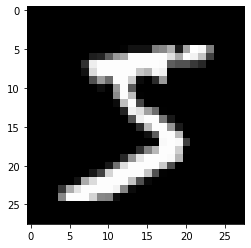

In [12]:
example = x_train[0]
plt.imshow(example, cmap="gray", vmin=0, vmax=255)

In [13]:
def calculate_conv_shape(X, K, padding=0, stride=1):
    """Calculate the shape of the output of a convolution 
    
    Args:
        X (np.array): The input matrix
        K (np.array): The filter matrix
        padding (int, optional): Defaults to 0. The padding dimension
        stride (int, optional): Defaults to 1. The stride of the convolution
    
    Returns:
        tuple: The shape of the convolution output (height followed by width)
    """
    # YOUR CODE HERE
    xw=X.shape[1]
    xh=X.shape[0]
    kw=K.shape[1]
    kh=K.shape[0]
    yw=int(((xw-kw+2*padding)/stride)+1)
    yh=int(((xh-kh+2*padding)/stride)+1)
    return yh, yw

Create simple CNN

In [15]:
simple_layers=[Flatten(),
               Dense(200, activation='relu', input_shape=(784,)),
               Dropout(.1),
               Dense(200, activation='relu'),
               Dropout(.05),
               Dense(10, activation='softmax'),
               ]
simple_model = keras.Sequential(simple_layers)


simple_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 58us/sample - loss: 1.8983 - accuracy: 0.8456
Epoch 2/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.3821 - accuracy: 0.9101
Epoch 3/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.2557 - accuracy: 0.9327
Epoch 4/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2139 - accuracy: 0.9426
Epoch 5/5
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2010 - accuracy: 0.9457


In [18]:
with suppress_stdout():
    simple_scores = simple_model.evaluate(x_test, y_test)
print(f"\nThe simple model achieves an accuracy of {simple_scores[1]*100:.2f}% on the test data with only 5 epochs.")


The simple model achieves an accuracy of 95.45% on the test data with only 5 epochs.


Now we'll create a CNN and see how it compares to our regular CNN. We'll use Conv2D for the convolutional layers and MaxPool2D for pooling.

For the convolutional layers below, use a 3*3 convolutional filter and be sure to set the padding.

In [19]:
cnn_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model=keras.Sequential(cnn_layers)

cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 41s 690us/sample - loss: 0.2386 - accuracy: 0.9461
Epoch 2/3
60000/60000 [==============================] - 42s 705us/sample - loss: 0.0749 - accuracy: 0.9781
Epoch 3/3
60000/60000 [==============================] - 44s 735us/sample - loss: 0.0717 - accuracy: 0.9799


In [24]:
with suppress_stdout():
    cnn_scores = cnn_model.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model achieves an accuracy of 98.25% on the test data.


Testing using Dropout in the model.

In [27]:
cnn_dropout_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.5),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
            Dropout(.5),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.5),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model_dropout=keras.Sequential(cnn_dropout_layers)

cnn_model_dropout.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_dropout.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 45s 745us/sample - loss: 0.7002 - accuracy: 0.7972
Epoch 2/3
60000/60000 [==============================] - 48s 797us/sample - loss: 0.2033 - accuracy: 0.9402
Epoch 3/3
60000/60000 [==============================] - 51s 850us/sample - loss: 0.1663 - accuracy: 0.9531


In [28]:
with suppress_stdout():
    cnn_scores = cnn_model_dropout.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model with .5 dropout achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model with .5 dropout achieves an accuracy of 96.00% on the test data.


In [29]:
cnn_dropout_layers=[Conv2D(32,kernel_size=(3,3), strides=(1,1), padding='same',activation='relu', input_shape=(28,28,1)),
          MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.2),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
            Dropout(.2),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'),
            Dropout(.2),
           MaxPool2D(pool_size=(2,2), strides=(2,2)),
           Flatten(),
           Dense(200, activation='relu'),
           Dense(200, activation='relu'),
           Dense(10, activation='softmax')]

cnn_model_dropout=keras.Sequential(cnn_dropout_layers)

cnn_model_dropout.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_dropout.fit(x_train.reshape(-1, 28, 28 ,1), y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 53s 879us/sample - loss: 0.3088 - accuracy: 0.9176
Epoch 2/3
60000/60000 [==============================] - 57s 952us/sample - loss: 0.1009 - accuracy: 0.9705
Epoch 3/3
60000/60000 [==============================] - 56s 933us/sample - loss: 0.0903 - accuracy: 0.9741


In [30]:
with suppress_stdout():
    cnn_scores = cnn_model_dropout.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)
print(f"\nThe CNN model with .2 dropout achieves an accuracy of {cnn_scores[1]*100:.2f}% on the test data.")


The CNN model with .2 dropout achieves an accuracy of 97.83% on the test data.
